In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram, find_peaks
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind
import datetime
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from sklearn.cluster import DBSCAN
import requests
from io import StringIO
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.stattools import grangercausalitytests
from pyinform.transferentropy import transfer_entropy
from tigramite.data_processing import DataFrame as TDF
from tigramite.pcmci import PCMCI
import pyinform
from sklearn.ensemble import IsolationForest
import yfinance as yf
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
from pytrends.request import TrendReq
from fredapi import Fred
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.utils import resample
from scipy.signal import hilbert
from dtaidistance import dtw
from scipy.signal import coherence, csd
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy.stats import pearsonr
import joblib
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pytz
from tqdm import tqdm
from scipy.stats import zscore
from scipy.ndimage import median_filter
from sklearn.metrics import precision_score, recall_score, f1_score
import ta
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import VotingClassifier
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting  # Нужно для активации
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import pandas_datareader.data as web
from tiingo import TiingoClient
from pykalman import KalmanFilter

# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

In [39]:
''' FUNCTIONS '''

# Конввертируем время в привычный вариант
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

def plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1H', show_signals=True, max_return=10.0):
    """
    Визуализация стратегии и сравнение с Buy & Hold.

    Parameters:
    - df_signals: DataFrame с колонками ['strategy_return', 'future_return', 'signal']
    - threshold: значение, использованное при генерации сигналов
    - resample: частота агрегации ('1H', '1D', 'W', и т.д.)
    - show_signals: если True — отмечает сделки на графике
    - max_return: максимальное значение cumulative return, выше которого обрезаются выбросы
    """
    df_plot = df_signals.copy()

    # Убедимся, что индекс — datetime
    df_plot.index = pd.to_datetime(df_plot.index)
    df_plot = df_plot.sort_index()

    # Пересчитаем кумулятивные доходности
    df_plot['cumulative_return'] = (1 + df_plot['strategy_return']).cumprod()
    df_plot['buy_and_hold'] = (1 + df_plot['future_return']).cumprod()

    # Удалим выбросы
    df_plot = df_plot[(df_plot['cumulative_return'] < max_return) & (df_plot['buy_and_hold'] < max_return)]

    # Агрегация
    df_plot = df_plot.resample(resample).last()

    # График
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.index, df_plot['cumulative_return'], label='Strategy')
    plt.plot(df_plot.index, df_plot['buy_and_hold'], label='Buy & Hold', linestyle='--')
    
    # Точки входа
    if show_signals and 'signal' in df_plot.columns:
        entry_points = df_plot[df_plot['signal'] == 1]
        plt.scatter(entry_points.index, entry_points['cumulative_return'], color='green', marker='^', label='Entries', zorder=5)

    plt.title(f'Strategy vs Buy & Hold (threshold={threshold}, resample={resample})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Strategy vs Buy & Hold", dpi=300)
    plt.show()

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),axis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

def compute_indicators_v6(df, trend_emd=None, future_horizon=5, threshold=0.02, kalman_smooth=False):

    if kalman_smooth:

        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        df = df.copy()
        
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            smoothed, _ = kf.smooth(df[col].values)
            df[col] = smoothed.flatten()
        
    price_orig = df['Close']

    # Если передан тренд из EMD — использовать его как очищенную цену для индикаторов (для снижения шума)
    price = trend_emd if trend_emd is not None else price_orig

    o, h, l, c, v = df['Open'], df['High'], df['Low'], df['Close'], df['Volume']

    # --- Скользящие средние ---
    df['sma_1d'] = price
    df['sma_1w'] = price.rolling(7).mean()
    df['sma_signal'] = (df['sma_1d'] > df['sma_1w']).astype(int)

    ema12 = price.ewm(span=12, adjust=False).mean()
    ema26 = price.ewm(span=26, adjust=False).mean()
    df['ema_crossover'] = (ema12 > ema26).astype(int)

    # --- RSI ---
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_signal'] = (df['rsi'] < 30).astype(int)

    # --- MACD ---
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    df['macd'] = macd
    df['macd_signal'] = macd_signal
    df['macd_signal_bin'] = (macd > macd_signal).astype(int)

    # --- Volatility ---
    window_size = 7
    df['volatility_1d'] = price.rolling(window=window_size).std()
    median_vol = df['volatility_1d'].median()
    df['volatility_signal'] = (df['volatility_1d'] > median_vol).astype(int)
    vol_roll = df['volatility_1d'].rolling(14)
    df['volatility_z'] = (df['volatility_1d'] - vol_roll.mean()) / (vol_roll.std() + 1e-8)

    # --- Bollinger Bands ---
    bb = ta.volatility.BollingerBands(close=price, window=20, window_dev=2)
    df['bb_hband_indicator'] = bb.bollinger_hband_indicator()
    df['bb_lband_indicator'] = bb.bollinger_lband_indicator()

    # --- ATR ---
    df['atr'] = ta.volatility.AverageTrueRange(high=h, low=l, close=c, window=14).average_true_range()

    # --- On Balance Volume ---
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=c, volume=v).on_balance_volume()

    # --- Stochastic RSI ---
    df['stoch_rsi'] = ta.momentum.StochasticOscillator(high=h, low=l, close=c, window=14).stoch()

    # --- Новые индикаторы ---

    # ADX - сила тренда
    df['adx'] = ta.trend.ADXIndicator(high=h, low=l, close=c, window=14).adx()

    # CCI - перепроданность/перекупленность
    df['cci'] = ta.trend.CCIIndicator(high=h, low=l, close=c, window=20).cci()

    # Williams %R
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high=h, low=l, close=c, lbp=14).williams_r()

    # Parabolic SAR
    df['psar'] = ta.trend.PSARIndicator(high=h, low=l, close=c, step=0.02, max_step=0.2).psar()

    # Momentum
    df['momentum'] = c - c.shift(10)

    # Chaikin Money Flow
    df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=h, low=l, close=c, volume=v, window=20).chaikin_money_flow()

    # --- Свечные паттерны ---
    df['bull_candle'] = (c > o).astype(int)
    df['bear_candle'] = (c < o).astype(int)
    hl_range = h - l + 1e-8
    df['hammer'] = ((h - l > 3 * abs(o - c)) &
                    ((c - l) / hl_range > 0.6) &
                    ((o - l) / hl_range > 0.6)).astype(int)
    df['doji'] = (abs(c - o) <= 0.05 * hl_range).astype(int)
    df['shooting_star'] = ((h - l > 3 * abs(o - c)) &
                           ((h - c) / hl_range > 0.6) &
                           ((h - o) / hl_range > 0.6)).astype(int)

    prev_c, prev_o = c.shift(1), o.shift(1)
    df['bullish_engulfing'] = ((prev_c < prev_o) & (c > o) & (c > prev_o) & (o < prev_c)).astype(int)
    df['bearish_engulfing'] = ((prev_c > prev_o) & (c < o) & (c < prev_o) & (o > prev_c)).astype(int)
    df['morning_star'] = ((df['bear_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bull_candle'] == 1)).astype(int)
    df['evening_star'] = ((df['bull_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bear_candle'] == 1)).astype(int)

    # --- Корреляции ---
    df['corr_price_volume_7'] = c.rolling(7).corr(v)
    df['corr_obv_price_7'] = df['obv'].rolling(7).corr(c)

    # --- Volume spike ---
    df['volume_spike'] = (v > 1.5 * v.rolling(14).mean()).astype(int)

    # --- Лаги ---
    lag_cols = ['Close', 'Volume', 'rsi', 'macd', 'macd_signal', 'obv', 'stoch_rsi', 'adx', 'cci', 'williams_r', 'momentum', 'cmf']
    for col in lag_cols:
        for lag in range(1, 4):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # --- Целевая переменная ---
    df['future_return'] = df['Close'].shift(-future_horizon) / df['Close'] - 1
    df['target'] = (df['future_return'] > threshold).astype(int)

    # --- Свечная кластеризация ---
    candle_features = pd.DataFrame({
        'body': abs(c - o),
        'upper_shadow': h - np.maximum(c, o),
        'lower_shadow': np.maximum(0, np.minimum(c, o) - l)
    }).replace([np.inf, -np.inf], 0).fillna(0)
    candle_scaled = StandardScaler().fit_transform(candle_features)
    kmeans = KMeans(n_clusters=6, random_state=42).fit(candle_scaled)
    df['candle_cluster'] = kmeans.labels_

    # --- Комбинированный сигнал ---
    signals = ['sma_signal', 'ema_crossover', 'rsi_signal', 'macd_signal_bin', 'volatility_signal']
    df['combined_signal'] = df[signals].sum(axis=1)

    # --- Заполнение пропусков ---
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)            # out shape: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]              # взять последний временной шаг (batch, hidden_dim)
        out = self.dropout(out)
        out = self.fc(out)               # (batch, 1)
        return out.view(-1)              # привести к (batch,), чтобы loss корректно считывал


# --- Кастомный Dataset ---
class SequenceDataset(Dataset):
    def __init__(self, X, y, timestamps):
        self.X = X
        self.y = y
        # Преобразуем все timestamps в строку
        self.timestamps = pd.to_datetime(timestamps).astype(str).tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.timestamps[idx]

# --- Создание последовательностей ---
def create_sequences(X, y, timesteps, horizon, timestamps):
    Xs, ys, ts = [], [], []

    for i in range(len(X) - timesteps - horizon + 1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps + horizon - 1])  # целевое значение через horizon
        ts.append(timestamps[i+timesteps + horizon - 1])  # timestamp для точки предсказания

    return np.array(Xs), np.array(ys), np.array(ts)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for i, batch in enumerate(loader):
        X_batch, y_batch, *_ = batch
        X_batch = X_batch.float().to(device)  # 👈 float32
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(loader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    losses, all_preds, all_targets, all_timestamps = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch, ts_batch = batch
            X_batch, y_batch = X_batch.float().to(device), y_batch.to(device)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            losses.append(loss.item())

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
            all_timestamps.extend(ts_batch)  # теперь это list[str]

    # Преобразуем строки обратно в Timestamp
    all_timestamps = pd.to_datetime(all_timestamps)

    return np.mean(losses), np.array(all_preds), np.array(all_targets), all_timestamps


# Загружаем датафрейм

In [4]:
path ='btcusd_1-min_data.csv'

In [20]:
btc_df = pd.read_csv(path,parse_dates=[0],
                 date_parser=dateparse,
                 index_col='Timestamp')

In [16]:
btc_df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 13:01:00+00:00,4.58,4.58,4.58,4.58,0.00
2012-01-01 13:02:00+00:00,4.58,4.58,4.58,4.58,0.00
2012-01-01 13:03:00+00:00,4.58,4.58,4.58,4.58,0.00
2012-01-01 13:04:00+00:00,4.58,4.58,4.58,4.58,0.00
2012-01-01 13:05:00+00:00,4.58,4.58,4.58,4.58,0.00
...,...,...,...,...,...
2025-06-12 03:43:00+00:00,"108,581.00","108,637.00","108,581.00","108,632.00",0.02
2025-06-12 03:44:00+00:00,"108,667.00","108,694.00","108,667.00","108,694.00",0.05
2025-06-12 03:45:00+00:00,"108,696.00","108,719.00","108,696.00","108,715.00",0.00


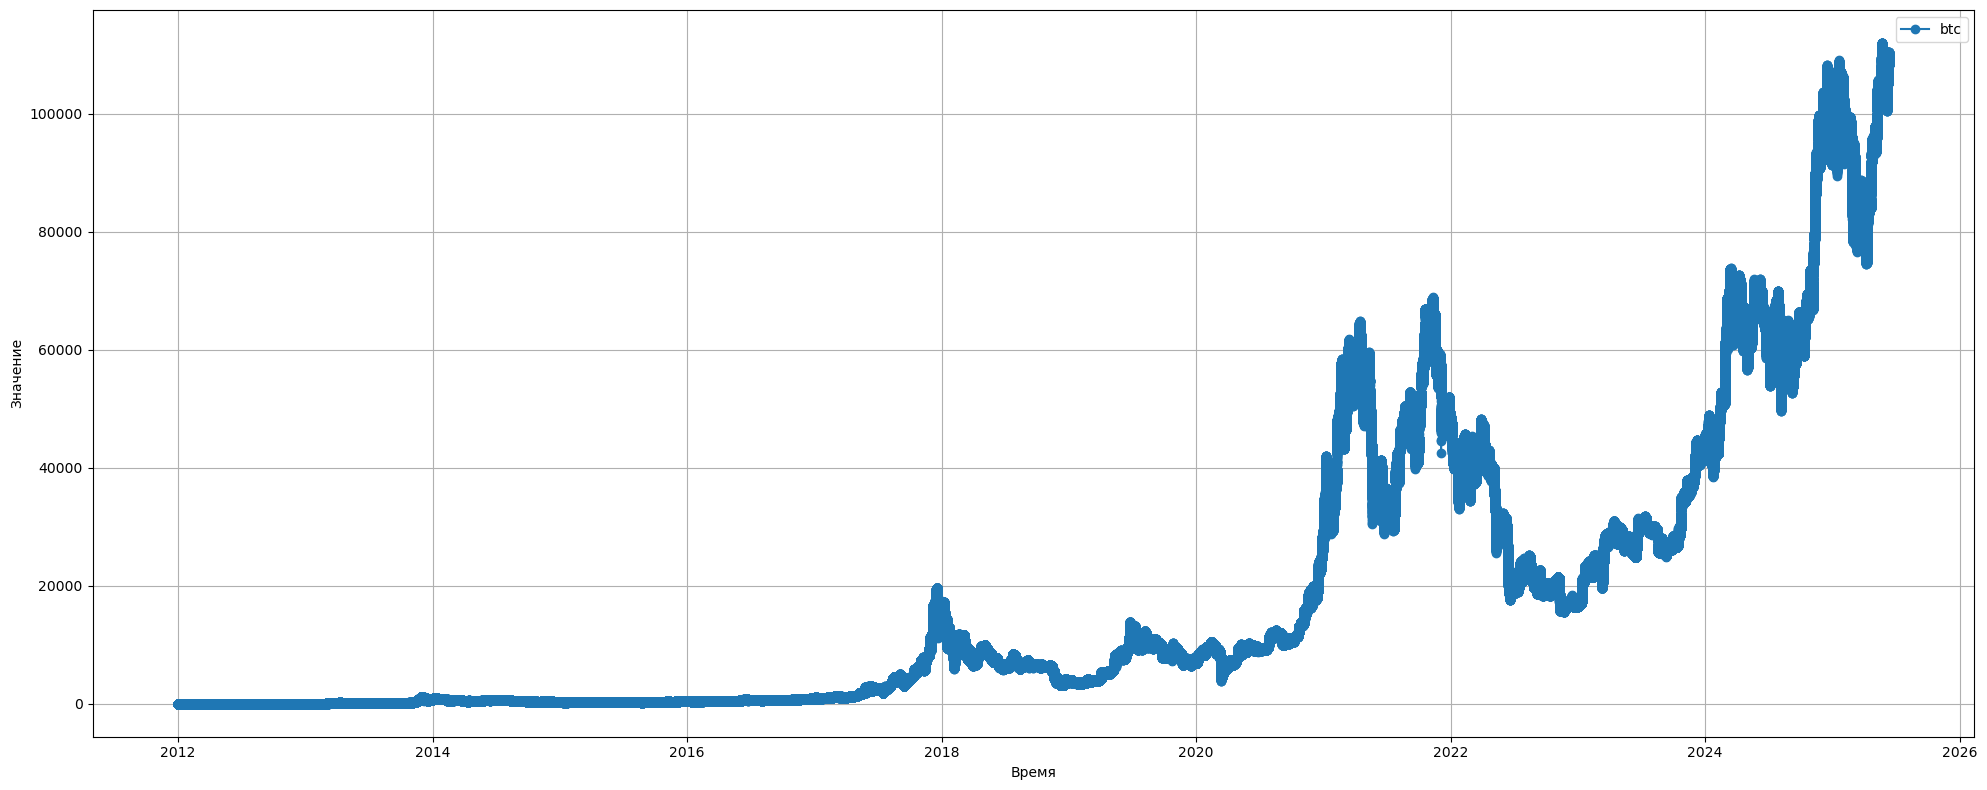

In [17]:
plt.figure(figsize=(20, 8))
plt.plot(btc_df['Close'], marker='o', label="btc")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

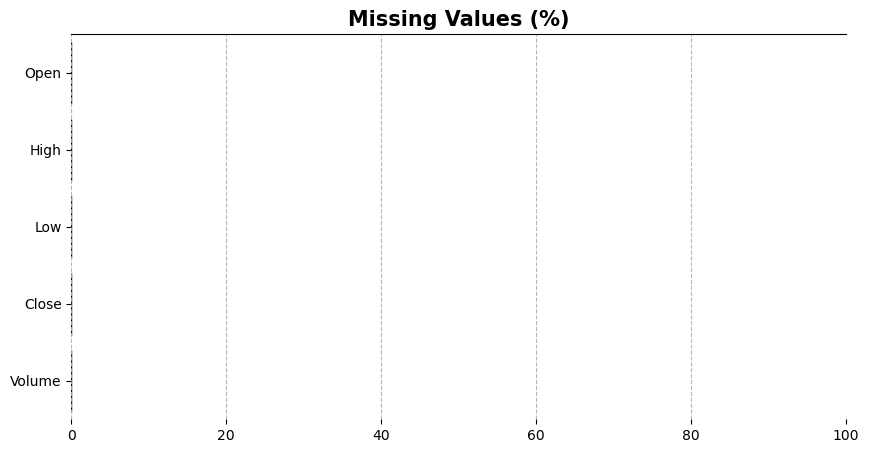

In [11]:
# Посмотрим что у нас с пропусками
NaN_values = (btc_df.isnull().sum()/len(btc_df)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [12]:
NaN_values

Open     0.00
High     0.00
Low      0.00
Close    0.00
Volume   0.00
dtype: float64

# 1.Готовим датайфрейм 

## 1.1 Подрезка с даты халвинга

In [21]:
btc_df_after_halving = btc_df[btc_df.index >= '2020-05-11']

In [22]:
btc_df_after_halving

,Open,High,Low,Close,Volume
Timestamp,,,,,
2020-05-11 00:00:00+00:00,"8,279.37","8,399.96","8,267.91","8,399.96",141.76
2020-05-11 00:01:00+00:00,"8,396.25","8,399.96","8,344.60","8,356.60",43.73
2020-05-11 00:02:00+00:00,"8,364.42","8,410.25","8,348.20","8,400.01",45.18
2020-05-11 00:03:00+00:00,"8,412.28","8,414.01","8,381.69","8,396.40",35.22
2020-05-11 00:04:00+00:00,"8,388.08","8,408.43","8,369.99","8,408.17",65.22
...,...,...,...,...,...
2025-06-12 03:43:00+00:00,"108,581.00","108,637.00","108,581.00","108,632.00",0.02
2025-06-12 03:44:00+00:00,"108,667.00","108,694.00","108,667.00","108,694.00",0.05
2025-06-12 03:45:00+00:00,"108,696.00","108,719.00","108,696.00","108,715.00",0.00


## 1.2 есемплим до 10 минутного интервала (если данные поминутные)

In [23]:
btc_df_after_halving.index = pd.to_datetime(btc_df_after_halving.index)

# Ресемплим до 10-минутных данных
btc_df_10min = btc_df_after_halving.resample('10T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

print(f'Размер после ресемплинга: {btc_df_10min.shape[0]} строк')

Размер после ресемплинга: 267460 строк


In [24]:
btc_df_10min

,Open,High,Low,Close,Volume
Timestamp,,,,,
2020-05-11 00:00:00+00:00,"8,279.37","8,482.06","8,267.91","8,480.74",483.30
2020-05-11 00:10:00+00:00,"8,468.25","8,494.12","8,417.82","8,494.12",151.57
2020-05-11 00:20:00+00:00,"8,505.82","8,600.00","8,474.04","8,512.56",580.53
2020-05-11 00:30:00+00:00,"8,523.50","8,553.24","8,483.91","8,546.27",155.17
2020-05-11 00:40:00+00:00,"8,535.00","8,539.43","8,480.00","8,490.37",112.31
...,...,...,...,...,...
2025-06-12 03:00:00+00:00,"108,670.00","108,691.00","108,594.00","108,665.00",0.48
2025-06-12 03:10:00+00:00,"108,665.00","108,699.00","108,612.00","108,665.00",0.70
2025-06-12 03:20:00+00:00,"108,677.00","108,833.00","108,563.00","108,563.00",4.51


## 1.3 Применение функции генерации техничксикх индексов

In [32]:
btc_with_ta = compute_indicators_v6(btc_df_10min, kalman_smooth=True)

In [34]:
btc_with_ta

,Open,High,Low,Close,Volume,sma_1d,sma_1w,sma_signal,ema_crossover,rsi,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00+00:00,"5,165.49","5,252.84","5,150.66","5,246.80",243.56,"5,246.80","7,762.15",0,0,98.98,...,"3,244.13","3,244.13","3,244.13",0.18,0.18,0.18,0.62,1,0,0
2020-05-11 00:10:00+00:00,"7,217.10","7,276.46","7,184.08","7,259.67",247.39,"7,259.67","7,762.15",0,1,98.98,...,"3,244.13","3,244.13","3,244.13",0.18,0.18,0.18,0.17,1,0,2
2020-05-11 00:20:00+00:00,"8,017.57","8,082.42","7,983.75","8,038.09",347.03,"8,038.09","7,762.15",0,1,98.98,...,"3,244.13","3,244.13","3,244.13",0.18,0.18,0.18,0.06,1,4,2
2020-05-11 00:30:00+00:00,"8,329.79","8,370.81","8,293.13","8,342.03",213.18,"8,342.03","7,762.15",0,1,98.98,...,"3,244.13","3,244.13","3,244.13",0.18,0.18,0.18,0.02,0,0,2
2020-05-11 00:40:00+00:00,"8,448.29","8,476.77","8,411.74","8,441.74",137.34,"8,441.74","7,762.15",0,1,98.98,...,"3,244.13","3,244.13","3,244.13",0.18,0.18,0.18,0.00,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12 03:00:00+00:00,"108,657.89","108,704.63","108,595.01","108,656.89",1.08,"108,656.89","108,615.65",1,0,51.39,...,208.32,109.83,87.16,0.01,0.01,0.01,-0.00,0,4,3
2025-06-12 03:10:00+00:00,"108,653.49","108,715.65","108,582.41","108,643.84",1.48,"108,643.84","108,634.70",1,0,55.67,...,286.12,208.32,109.83,0.01,0.01,0.01,-0.00,0,4,2
2025-06-12 03:20:00+00:00,"108,637.57","108,743.33","108,540.24","108,609.63",2.66,"108,609.63","108,641.90",0,0,55.39,...,327.05,286.12,208.32,0.01,0.01,0.01,-0.00,0,1,1


In [35]:
btc_with_ta_nokalman = compute_indicators_v6(btc_df_10min)

In [33]:
# # Сохраняем
# btc_with_ta.to_csv('btc_with_ta.csv')
# btc_df_10min.to_csv('btc_df_10min.csv')
# btc_with_ta_nokalman.to_csv('btc_with_ta_nokalman.csv')

In [ ]:
btc_with_ta = pd.read_csv('btc_with_ta.csv')
btc_df_10min = pd.read_csv('btc_df_10min.csv')
btc_with_ta_nokalman = = pd.read_csv('btc_with_ta_nokalman.csv')

# 2. Присоединение криптоиндексов BITW, CCI30

# 3. Присоединение биржевого индекса QQQ (nasdaq) -нужна интерполяция на выходных

# 4. Присоединение индекса голода/жадности (факультативно)

# 5.Обучение модели (грузим один из набьоров данных)

## 5.1 На данных после чистки отшумов

In [ ]:
btc_with_ta = pd.read_csv('btc_with_ta.csv')

In [40]:
# Удаляем строки с NaN или бесконечностями
df_clean_with_kal = btc_with_ta.drop(columns=['future_return','High', 'Close', 'Low', 'Open']).copy()
df_clean_with_kal = df_clean_with_kal.replace([np.inf, -np.inf], np.nan).dropna()

# Преобразуем целевую переменную
y = df_clean_with_kal['target'].values.astype(np.float32)
X = df_clean_with_kal.drop(columns=['target']).values

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# Создаем последовательности
TIMESTEPS = 10
X_seq, y_seq, ts_seq = create_sequences(X_scaled, y, TIMESTEPS, horizon=1008, timestamps=df_clean_with_kal.index)

In [43]:
# --- Разделение на train/val/test ---
dataset = SequenceDataset(X_seq, y_seq.astype(np.float32), ts_seq)
train_size = int(len(dataset)*0.6)
val_size = int(len(dataset)*0.2)
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [44]:
# === Обучение ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model10min_with_kal = LSTMClassifier(input_dim=X_seq.shape[2], hidden_dim=64, num_layers=2, dropout=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model10min_with_kal.parameters(), lr=1e-3)

/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# --- Тренировка с early stopping ---
EPOCHS = 100
best_val_loss = np.inf
patience = 15
counter = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model10min_with_kal, train_loader, criterion, optimizer, device)
    val_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_kal, val_loader, criterion, device)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model10min_with_kal.state_dict(), "model10min_with_kal.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.0267, Val Loss=0.0272
Epoch 2: Train Loss=0.0259, Val Loss=0.0265
Epoch 3: Train Loss=0.0249, Val Loss=0.0255
Epoch 4: Train Loss=0.0239, Val Loss=0.0251
Epoch 5: Train Loss=0.0230, Val Loss=0.0248
Epoch 6: Train Loss=0.0220, Val Loss=0.0239
Epoch 7: Train Loss=0.0202, Val Loss=0.0254
Epoch 8: Train Loss=0.0197, Val Loss=0.0228
Epoch 9: Train Loss=0.0183, Val Loss=0.0237
Epoch 10: Train Loss=0.0175, Val Loss=0.0222
Epoch 11: Train Loss=0.0167, Val Loss=0.0224
Epoch 12: Train Loss=0.0158, Val Loss=0.0217
Epoch 13: Train Loss=0.0150, Val Loss=0.0225
Epoch 14: Train Loss=0.0147, Val Loss=0.0212
Epoch 15: Train Loss=0.0139, Val Loss=0.0211
Epoch 16: Train Loss=0.0136, Val Loss=0.0203
Epoch 17: Train Loss=0.0128, Val Loss=0.0207
Epoch 18: Train Loss=0.0125, Val Loss=0.0215
Epoch 19: Train Loss=0.0118, Val Loss=0.0194
Epoch 20: Train Loss=0.0120, Val Loss=0.0196
Epoch 21: Train Loss=0.0110, Val Loss=0.0196
Epoch 22: Train Loss=0.0109, Val Loss=0.0199
Epoch 23: Train Los

In [47]:
# Загрузка лучшей модели
model10min_with_kal.load_state_dict(torch.load("model10min_with_kal.pth"))
model10min_with_kal.eval()

# Предсказания на тесте
test_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_kal, test_loader, criterion, device)

# Получение вероятностей (sigmoid)
probas = torch.sigmoid(torch.tensor(test_preds)).numpy()

# Бинарные метки по порогу 0.5
pred_labels = (probas > 0.5).astype(int)

Accuracy: 0.9962
F1-score: 0.4377
ROC AUC: 0.9013


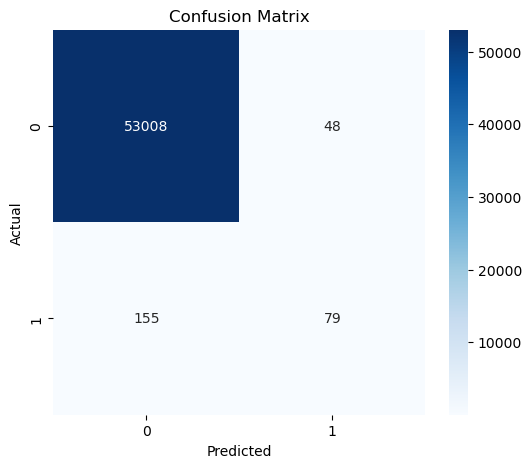

In [48]:
accuracy = accuracy_score(test_targets, pred_labels)
f1 = f1_score(test_targets, pred_labels)
roc_auc = roc_auc_score(test_targets, probas)
cm = confusion_matrix(test_targets, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# --- Настройка ---
threshold = 0.6  # Порог вероятности для входа в сделку

# Убедимся, что длина совпадает
assert len(probas) == len(timestamps)

# --- Привяжем вероятности к df ---
df_signals = pd.DataFrame({
    'timestamp': timestamps,
    'proba': probas
})
df_signals = df_signals.set_index('timestamp')
df_signals['signal'] = (df_signals['proba'] > threshold).astype(int)

# Добавим будущую доходность (временные метки должны совпадать!)
df_signals['future_return'] = btc_with_ta.loc[df_signals.index, 'future_return']

# --- Доходность стратегии ---
df_signals['strategy_return'] = df_signals['signal'] * df_signals['future_return']
df_signals['cumulative_return'] = (1 + df_signals['strategy_return']).cumprod()
df_signals['buy_and_hold'] = (1 + df_signals['future_return']).cumprod()

# --- Метрики ---
total_trades = df_signals['signal'].sum()
avg_return = df_signals[df_signals['signal'] == 1]['strategy_return'].mean()
hit_rate = (df_signals[df_signals['signal'] == 1]['future_return'] > 0).mean()

print(f"📊 Кол-во сделок: {total_trades}")
print(f"📈 Средний доход на сделку: {avg_return:.4f}")
print(f"✅ Доля прибыльных сделок: {hit_rate:.2%}")

📊 Кол-во сделок: 102
📈 Средний доход на сделку: 0.0247
✅ Доля прибыльных сделок: 97.06%


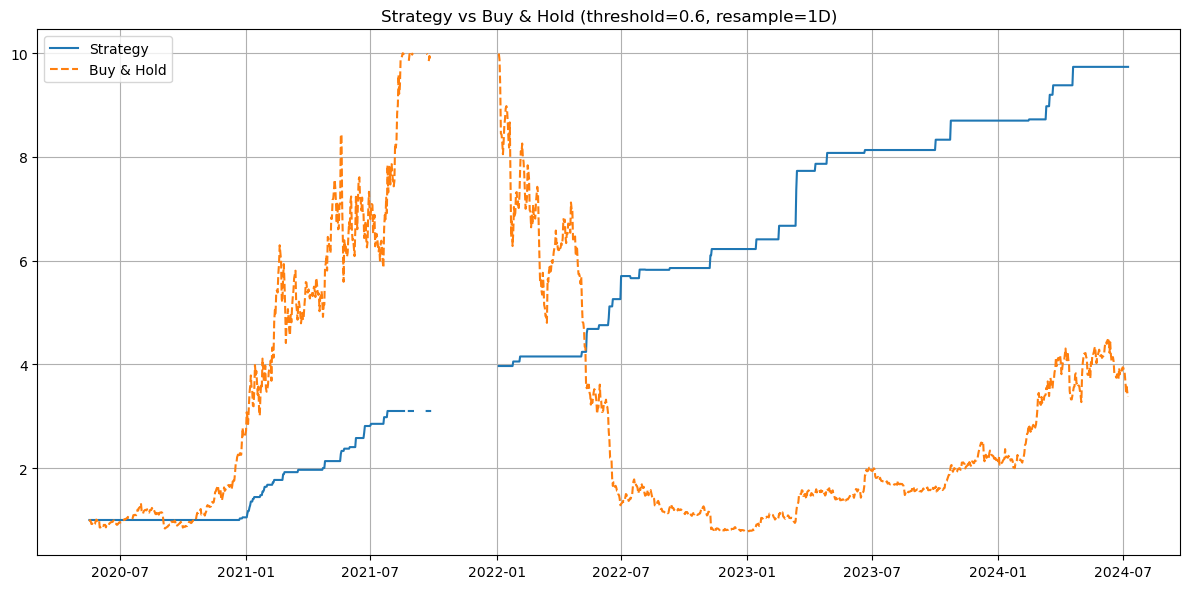

In [51]:
plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1D', show_signals=False)

## 5.2 На данных без чистки от шумов

In [ ]:
btc_with_ta_nokalman = = pd.read_csv('btc_with_ta_nokalman.csv')

In [52]:
# Удаляем строки с NaN или бесконечностями
df_clean_with_nokal = btc_with_ta_nokalman.drop(columns=['future_return','High', 'Close', 'Low', 'Open']).copy()
df_clean_with_nokal = df_clean_with_nokal.replace([np.inf, -np.inf], np.nan).dropna()

# Преобразуем целевую переменную
y = df_clean_with_nokal['target'].values.astype(np.float32)
X = df_clean_with_nokal.drop(columns=['target']).values

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
# Создаем последовательности
TIMESTEPS = 10
X_seq, y_seq, ts_seq = create_sequences(X_scaled, y, TIMESTEPS, horizon=1008, timestamps=df_clean_with_kal.index)

In [54]:
# --- Разделение на train/val/test ---
dataset = SequenceDataset(X_seq, y_seq.astype(np.float32), ts_seq)
train_size = int(len(dataset)*0.6)
val_size = int(len(dataset)*0.2)
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [55]:
# === Обучение ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model10min_with_nokal = LSTMClassifier(input_dim=X_seq.shape[2], hidden_dim=64, num_layers=2, dropout=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model10min_with_nokal.parameters(), lr=1e-3)

In [56]:
# --- Тренировка с early stopping ---
EPOCHS = 100
best_val_loss = np.inf
patience = 15
counter = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model10min_with_nokal, train_loader, criterion, optimizer, device)
    val_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_nokal, val_loader, criterion, device)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model10min_with_nokal.state_dict(), "model10min_with_nokal.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.0436, Val Loss=0.0428
Epoch 2: Train Loss=0.0404, Val Loss=0.0423
Epoch 3: Train Loss=0.0392, Val Loss=0.0415
Epoch 4: Train Loss=0.0379, Val Loss=0.0432
Epoch 5: Train Loss=0.0365, Val Loss=0.0405
Epoch 6: Train Loss=0.0350, Val Loss=0.0399
Epoch 7: Train Loss=0.0337, Val Loss=0.0400
Epoch 8: Train Loss=0.0324, Val Loss=0.0384
Epoch 9: Train Loss=0.0308, Val Loss=0.0395
Epoch 10: Train Loss=0.0297, Val Loss=0.0397
Epoch 11: Train Loss=0.0281, Val Loss=0.0368
Epoch 12: Train Loss=0.0271, Val Loss=0.0366
Epoch 13: Train Loss=0.0259, Val Loss=0.0376
Epoch 14: Train Loss=0.0243, Val Loss=0.0370
Epoch 15: Train Loss=0.0236, Val Loss=0.0364
Epoch 16: Train Loss=0.0224, Val Loss=0.0355
Epoch 17: Train Loss=0.0220, Val Loss=0.0344
Epoch 18: Train Loss=0.0205, Val Loss=0.0369
Epoch 19: Train Loss=0.0205, Val Loss=0.0370
Epoch 20: Train Loss=0.0196, Val Loss=0.0342
Epoch 21: Train Loss=0.0189, Val Loss=0.0366
Epoch 22: Train Loss=0.0186, Val Loss=0.0367
Epoch 23: Train Los

In [57]:
# Загрузка лучшей модели
model10min_with_nokal.load_state_dict(torch.load("model10min_with_nokal.pth"))
model10min_with_nokal.eval()

# Предсказания на тесте
test_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_nokal, test_loader, criterion, device)

# Получение вероятностей (sigmoid)
probas = torch.sigmoid(torch.tensor(test_preds)).numpy()

# Бинарные метки по порогу 0.5
pred_labels = (probas > 0.5).astype(int)

Accuracy: 0.9926
F1-score: 0.2852
ROC AUC: 0.8480


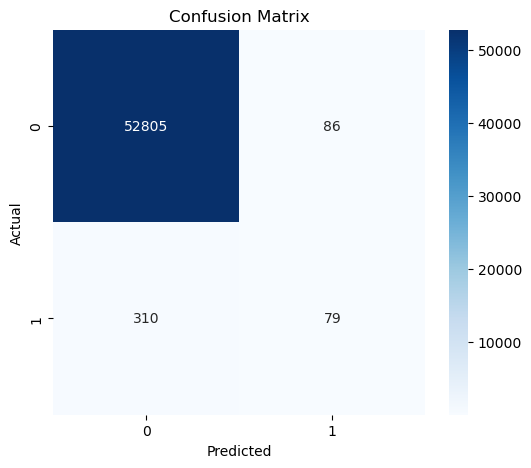

In [58]:
accuracy = accuracy_score(test_targets, pred_labels)
f1 = f1_score(test_targets, pred_labels)
roc_auc = roc_auc_score(test_targets, probas)
cm = confusion_matrix(test_targets, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [59]:
# --- Настройка ---
threshold = 0.6  # Порог вероятности для входа в сделку

# Убедимся, что длина совпадает
assert len(probas) == len(timestamps)

# --- Привяжем вероятности к df ---
df_signals = pd.DataFrame({
    'timestamp': timestamps,
    'proba': probas
})
df_signals = df_signals.set_index('timestamp')
df_signals['signal'] = (df_signals['proba'] > threshold).astype(int)

# Добавим будущую доходность (временные метки должны совпадать!)
df_signals['future_return'] = btc_with_ta_nokalman.loc[df_signals.index, 'future_return']

# --- Доходность стратегии ---
df_signals['strategy_return'] = df_signals['signal'] * df_signals['future_return']
df_signals['cumulative_return'] = (1 + df_signals['strategy_return']).cumprod()
df_signals['buy_and_hold'] = (1 + df_signals['future_return']).cumprod()

# --- Метрики ---
total_trades = df_signals['signal'].sum()
avg_return = df_signals[df_signals['signal'] == 1]['strategy_return'].mean()
hit_rate = (df_signals[df_signals['signal'] == 1]['future_return'] > 0).mean()

print(f"📊 Кол-во сделок: {total_trades}")
print(f"📈 Средний доход на сделку: {avg_return:.4f}")
print(f"✅ Доля прибыльных сделок: {hit_rate:.2%}")

📊 Кол-во сделок: 138
📈 Средний доход на сделку: 0.0001
✅ Доля прибыльных сделок: 55.80%


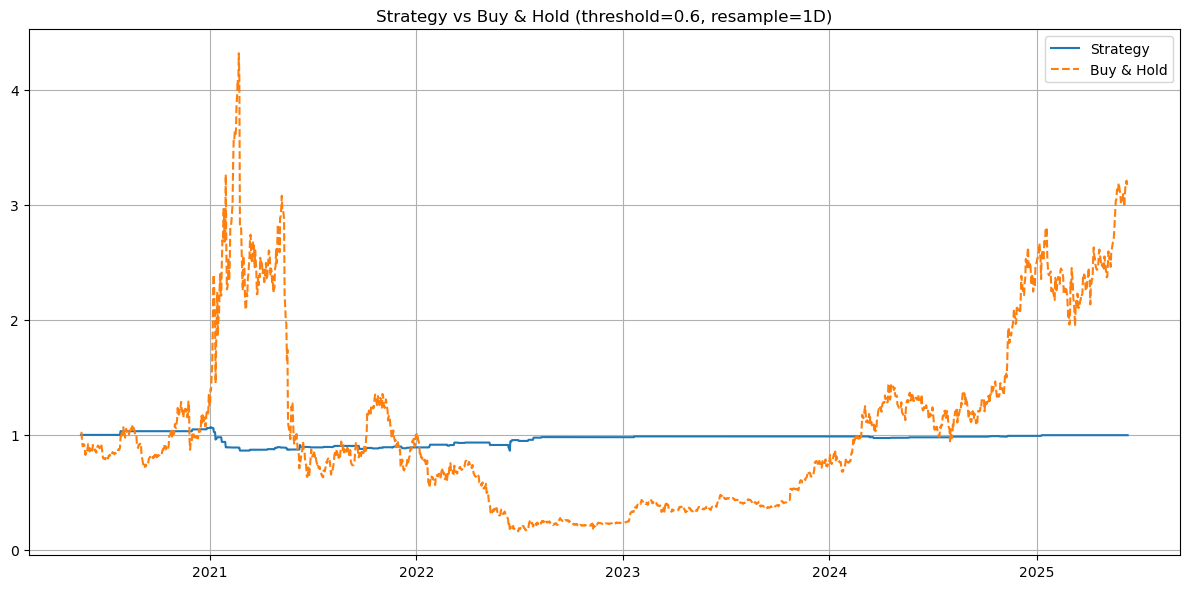

In [60]:
plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1D', show_signals=False)